### Preparation

In [137]:
import tqdm
import os
import cv2
import imghdr

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy

from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data_dir = 'D:\DATASETS\For-Thesis\Labels'

In [3]:
def sample_count(data_dir):
    for dir in os.listdir(data_dir):
        print("{}: {}".format(dir, len(os.listdir(os.path.join(data_dir,dir)))))

In [4]:
sample_count(data_dir)

Asphalt Road: 50
Building: 56
Concrete Road: 122
Plant: 68
Vehicle: 63


In [51]:
labels = ['Asphalt Road', 'Building', 'Concrete Road', 'Plant', 'Vehicle']
X_train = []
X_train_RGB = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
        X_train_RGB.append(img[...,::-1])  # cv2 opens it as BGR. This converts BGR to RGB
        y_label_idx.append(labels.index(i))

In [56]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train_RGB = np.array(X_train_RGB)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0
X_train_RGB_scaled = X_train_RGB.astype(np.float32) / 255.0
y_one_hot = tf.keras.utils.to_categorical(y_label_idx)

In [57]:
y_one_hot[0]

array([1., 0., 0., 0., 0.], dtype=float32)

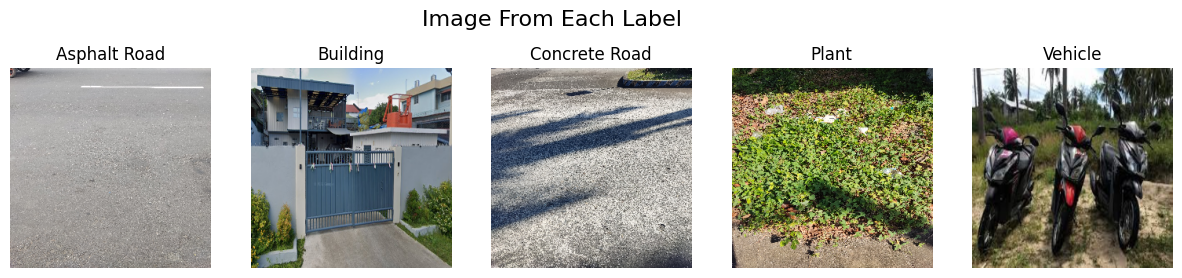

In [58]:
fig, ax = plt.subplots(1,5,figsize=(15,15))
fig.text(s='Image From Each Label', y=0.59, x=0.4, fontsize=16)
k = 0
idx = []
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[k].imshow(X_train_RGB_scaled[j]) 
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k += 1
            idx.append(j)
            break
        j += 1

### Prepare Dataset

In [59]:
idx

[0, 50, 106, 228, 296]

In [60]:
a_road = X_train_RGB_scaled[0:50]
a_road_label = y_one_hot[0:50]

b = X_train_RGB_scaled[50:106]
b_label = y_one_hot[50:106]

c_road = X_train_RGB_scaled[106:228]
c_road_label = y_one_hot[106:228]

p = X_train_RGB_scaled[228:296]
p_label = y_one_hot[228:296]

v = X_train_RGB_scaled[296:]
v_label = y_one_hot[296:]

In [61]:
a_dataset = tf.data.Dataset.from_tensor_slices((a_road, a_road_label))
b_dataset = tf.data.Dataset.from_tensor_slices((b, b_label))
c_dataset = tf.data.Dataset.from_tensor_slices((c_road, c_road_label))
p_dataset = tf.data.Dataset.from_tensor_slices((p, p_label))
v_dataset = tf.data.Dataset.from_tensor_slices((v, v_label))

In [62]:
len(a_dataset)

50

In [63]:
def base_shuffle(df):
    return df.shuffle(buffer_size=df.cardinality(), seed=1)

In [64]:
a_dataset_b = base_shuffle(a_dataset)
b_dataset_b = base_shuffle(b_dataset)
c_dataset_b = base_shuffle(c_dataset)
p_dataset_b = base_shuffle(p_dataset)
v_dataset_b = base_shuffle(v_dataset)

In [65]:
len(a_dataset_b)

50

In [66]:
def train_test(ds, mode='train'):
    size = len(ds)
    train_count = (size * 4) // 5   # ~80% of samples will be training data
    test_count = size - train_count
    train_set = ds.take(train_count)
    test_set = ds.skip(train_count).take(test_count)
    if mode == 'train':
        return train_set
    else:
        return test_set

In [67]:
aa_train = train_test(a_dataset_b)
aa_test = train_test(a_dataset_b, mode='test')

bb_train = train_test(b_dataset_b)
bb_test = train_test(b_dataset_b, mode='test')

cc_train = train_test(c_dataset_b)
cc_test = train_test(c_dataset_b, mode='test')

pp_train = train_test(p_dataset_b)
pp_test = train_test(p_dataset_b, mode='test')

vv_train = train_test(v_dataset_b)
vv_test = train_test(v_dataset_b, mode='test')

In [68]:
# Concatenate training sets and testing sets
combined_train_dataset = aa_train.concatenate(bb_train)
combined_train_dataset = combined_train_dataset.concatenate(cc_train)
combined_train_dataset = combined_train_dataset.concatenate(pp_train)
combined_train_dataset = combined_train_dataset.concatenate(vv_train)

In [69]:
len(combined_train_dataset)

285

In [70]:
combined_train_dataset = combined_train_dataset.shuffle(buffer_size=combined_train_dataset.cardinality()).batch(8)
combined_train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [71]:
combined_test_dataset = aa_test.concatenate(bb_test)
combined_test_dataset = combined_test_dataset.concatenate(cc_test)
combined_test_dataset = combined_test_dataset.concatenate(pp_test)
combined_test_dataset = combined_test_dataset.concatenate(vv_test)

In [72]:
combined_test_dataset = combined_test_dataset.shuffle(buffer_size=combined_test_dataset.cardinality()).batch(8)
combined_test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [76]:
train_set, val_set = tf.keras.utils.split_dataset(dataset=combined_train_dataset, left_size=0.8, shuffle=True, seed=1)

In [80]:
train_set, val_set

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

### Make Model

In [89]:
model = Sequential()
model.add(RandomFlip(mode='horizontal_and_vertical', seed=1, input_shape=(256,256,3)))
model.add(RandomRotation(factor=0.2, seed=1))

model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=64,activation="relu"))

model.add(Dense(units=5, activation="softmax"))
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_9 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_9 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 128, 128, 16)     

In [91]:
file_name = 'Model_V3-0-0'
log_dir = f'./logs/{file_name}'
checkpoint_filepath = f'./checkpoints/{file_name}'

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                             histogram_freq=1,
                                             profile_batch=2,
                                             write_graph=True,
                                             write_images=True,
                                            )
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_accuracy', 
                                                         mode='auto', 
                                                         save_best_only=True, 
                                                         verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.3, 
                                                 patience=2, 
                                                 min_delta=0.001, 
                                                 mode='auto', 
                                                 verbose=1)

### Train and Inspect Model

In [92]:
hist = model.fit(train_set, 
                 validation_data=val_set, 
                 epochs=10,
                 verbose=1,
                 callbacks=[tb_callback, es_callback, cp_callback, reduce_lr])

Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 4.6331 - accuracy: 0.4254
Epoch 1: val_accuracy improved from -inf to 0.12281, saving model to ./checkpoints\Model_V3-0-0
INFO:tensorflow:Assets written to: ./checkpoints\Model_V3-0-0\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V3-0-0\assets


29/29 [==============================] - 15s 368ms/step - loss: 4.6331 - accuracy: 0.4254 - val_loss: 2.2968 - val_accuracy: 0.1228 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 2.1652 - accuracy: 0.5658
Epoch 2: val_accuracy improved from 0.12281 to 0.42105, saving model to ./checkpoints\Model_V3-0-0
INFO:tensorflow:Assets written to: ./checkpoints\Model_V3-0-0\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V3-0-0\assets


29/29 [==============================] - 10s 347ms/step - loss: 2.1652 - accuracy: 0.5658 - val_loss: 2.4121 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 1.5322 - accuracy: 0.5921
Epoch 3: val_accuracy did not improve from 0.42105
29/29 [==============================] - 5s 181ms/step - loss: 1.5322 - accuracy: 0.5921 - val_loss: 2.4932 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 1.1169 - accuracy: 0.6974
Epoch 4: val_accuracy did not improve from 0.42105

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
29/29 [==============================] - 5s 188ms/step - loss: 1.1169 - accuracy: 0.6974 - val_loss: 2.1678 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 5/10
29/29 [==============================] - ETA: 0s - loss: 0.7806 - accuracy: 0.7193
Epoch 5: val_accuracy did not improve from 0.42105
29/29 [==============================] - 5s 180ms/step 

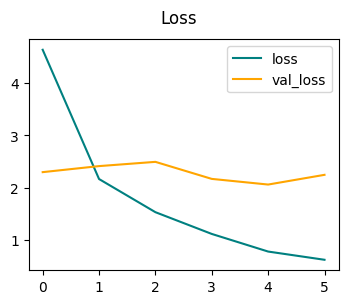

In [93]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

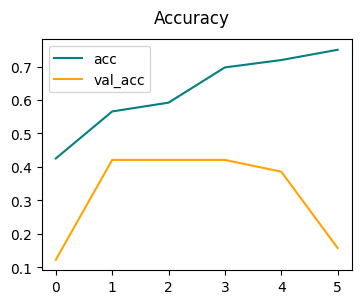

In [94]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

### Evaluate Model

In [138]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [139]:
for batch in combined_test_dataset.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 62ms/step


In [150]:
def print_scores(f1, pre, rec, c_acc):
    f1_score = f1.result().numpy() * 100
    pre_score = pre.result().numpy() * 100
    rec_score = rec.result().numpy() * 100
    c_acc_score = c_acc.result().numpy() * 100
    print(f"Precision: {pre_score:.2f}")
    print(f"Recall: {rec_score:.2f}")
    print(f"Categorical Accuracy: {c_acc_score:.2f}")
    print("F1 Score: ", f1_score)

In [151]:
print_scores(f1, pre, rec, c_acc)

Precision: 23.88
Recall: 21.62
Categorical Accuracy: 24.32
F1 Score:  [27.027025 13.333334 43.75      0.        0.      ]


In [142]:
test_result = model.evaluate(combined_test_dataset, return_dict=True, verbose=2)
print(test_result)

10/10 - 0s - loss: 2.1794 - accuracy: 0.2568 - 467ms/epoch - 47ms/step
{'loss': 2.1793811321258545, 'accuracy': 0.2567567527294159}


### More Visualization

In [145]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [146]:
# AppData/Local/Temp/.tensorboard-info - delete folder if it cannot load
%tensorboard --logdir=logs/